In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import keras

# Array of dictionaries of the labels at their indeces
azimuth_values = [270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
elevation_values= [60, 45, 30, 20, 10, 0, -10, -20, -30, -45]
positions_dict = []
for az in azimuth_values: 
  for el in elevation_values:
    positions_dict.append({'azimuth': az, 'elevation': el})


# take index of max probability class from the output probability array: creates array of predicted labels
def max_multi_pred(predict):
    max_preds = []
    max_probs = []
    for i in range(len(predict)):
        max1 = 0
        max2 = 0
        prob1 = 0
        prob2 = 0
        for j in range(len(predict[i])):
            if predict[i][j] > predict[i][max1]:
                max2 = max1
                max1 = j
                prob2 = prob1
                prob1 = predict[i][j]
                # print("max1: ", max1)
            elif predict[i][j] > predict[i][max2]:
                max2 = j
                prob2 = predict[i][j]
        max_preds.append(np.array([max1, max2]))
        max_probs.append(np.array([prob1, prob2]))
    return max_preds, max_probs

# altered square function that is explained in thesis
def sqr_error(t, p):
    err_az = abs( float(positions_dict[t]['azimuth']) - float(positions_dict[p]['azimuth']) )**2 + 0.1
    err_el = abs( float(positions_dict[t]['elevation']) - float(positions_dict[p]['elevation']) )**2 + 0.1
    return (err_az * err_el)

# correctly pairing the true-predict label pairs
def extract_label_pairs(true, predict):
    correct_pairs = []
    for i in range(len(predict)):
        max1 = 0
        max2 = 0
        o1 = sqr_error(true[i][0], predict[i][0]) * sqr_error(true[i][1], predict[i][1])
        o2 = sqr_error(true[i][1], predict[i][0]) * sqr_error(true[i][0], predict[i][1])
        if o1 < o2:
            max1 = predict[i][0]
            max2 = predict[i][1]
        else:
            max1 = predict[i][1]
            max2 = predict[i][0]
        pairs = [max1, max2]
        correct_pairs.append(pairs)
    correct_pairs = np.array(correct_pairs)
    return correct_pairs


In [2]:
# putting predictions in bins of azimuth
def to_az(labels):
    to_az = []
    for t in labels:
        label_az = t // 10
        to_az.append(label_az)
    to_az = np.array(to_az)
    return to_az

#putting predictions in bins of elevation
def to_el(labels):
    to_el = []
    for t in labels:
        label_el = t % 10
        to_el.append(label_el)
    to_el = np.array(to_el)
    return to_el

#plotting confusion matrices
def confusion_matrices(true_labels, predict_labels, label_k):
    print("total accuracy: ", metrics.accuracy_score(true_labels, predict_labels))
    true_az = to_az(true_labels)
    pred_az = to_az(predict_labels)
    true_el = to_el(true_labels)
    pred_el = to_el(predict_labels)
    print("accuracy azimuth: ", metrics.accuracy_score(true_az, pred_az))
    print("accuracy elevation: ", metrics.accuracy_score(true_el, pred_el))

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(17.5, 8), constrained_layout = True)
    fig.suptitle(f'Confusion matrix {label_k}', size = 20)
    ax1.set_title("Azimuth", fontsize = 16)
    ax2.set_title("Elevation", fontsize = 16)
    
    cma_display = metrics.ConfusionMatrixDisplay.from_predictions(true_az, 
                                                                  pred_az, 
                                                                  display_labels = [270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 
                                                                  10, 20, 30, 40, 50, 60, 70, 80, 90],
                                                                  xticks_rotation='vertical', 
                                                                  include_values = True, 
                                                                  ax = ax1, 
                                                                  normalize = 'true', 
                                                                  values_format= '.0%')

    
    confusion_matrix_el = metrics.confusion_matrix(true_el, pred_el)
    cm_display = metrics.ConfusionMatrixDisplay.from_predictions(true_el, pred_el, 
                                               display_labels = [60, 45, 30, 20, 10, 0, -10, -20, -30, -45],
                                                              xticks_rotation='vertical', include_values = True, ax = ax2, normalize = 'true', values_format= '.0%')
    

    plt.show()    

# function to take the first (m=0) or second (m=1) label pairing of the label array (labs)
def label_spec(labs, m):
    lis = []
    for i in range(len(labs)):
        lis.append(labs[i][m])
    lis = np.array(lis)
    return lis

total accuracy:  0.01721777590564448
accuracy azimuth:  0.11099410278011794
accuracy elevation:  0.15906697556866048


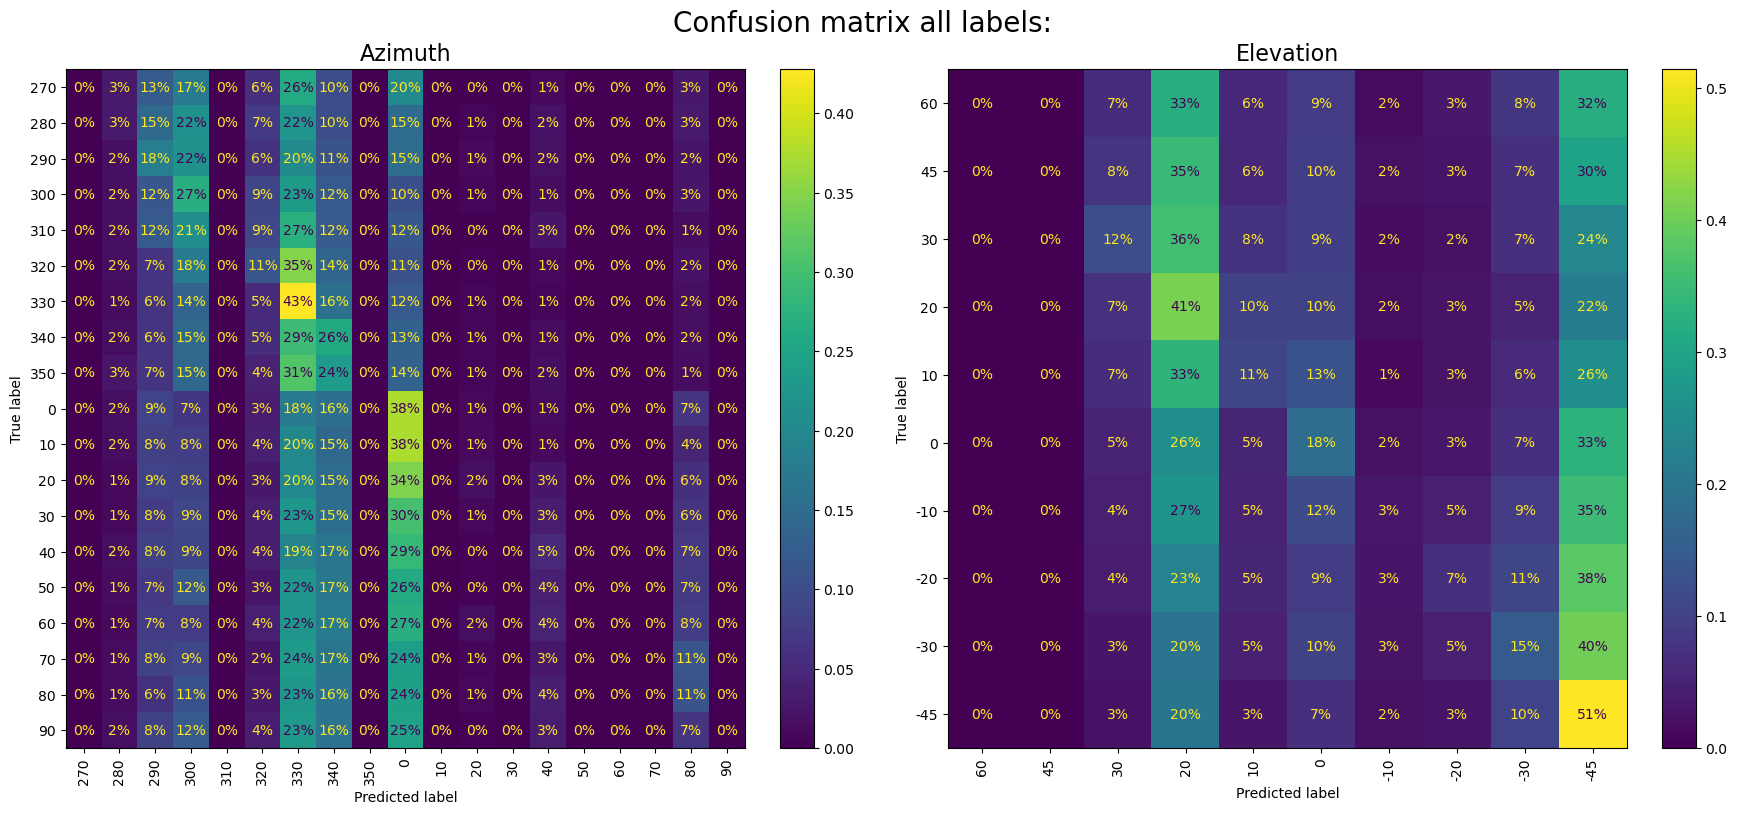

total accuracy:  0.010741364785172704
accuracy azimuth:  0.09856781802864364
accuracy elevation:  0.16143639427127213


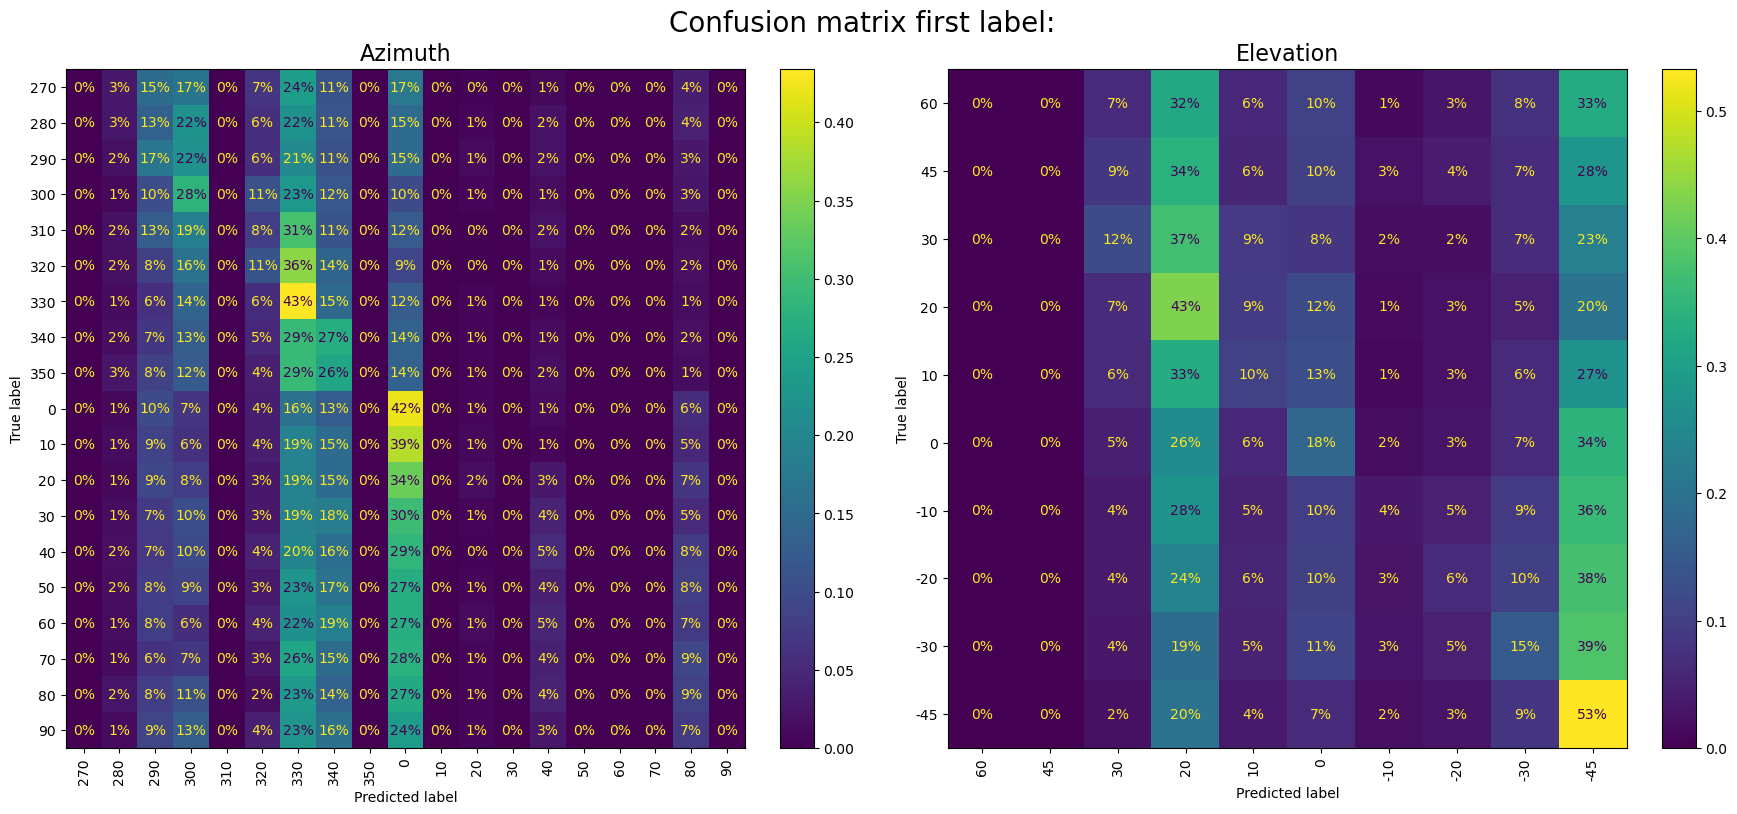

total accuracy:  0.02369418702611626
accuracy azimuth:  0.12342038753159225
accuracy elevation:  0.15669755686604886


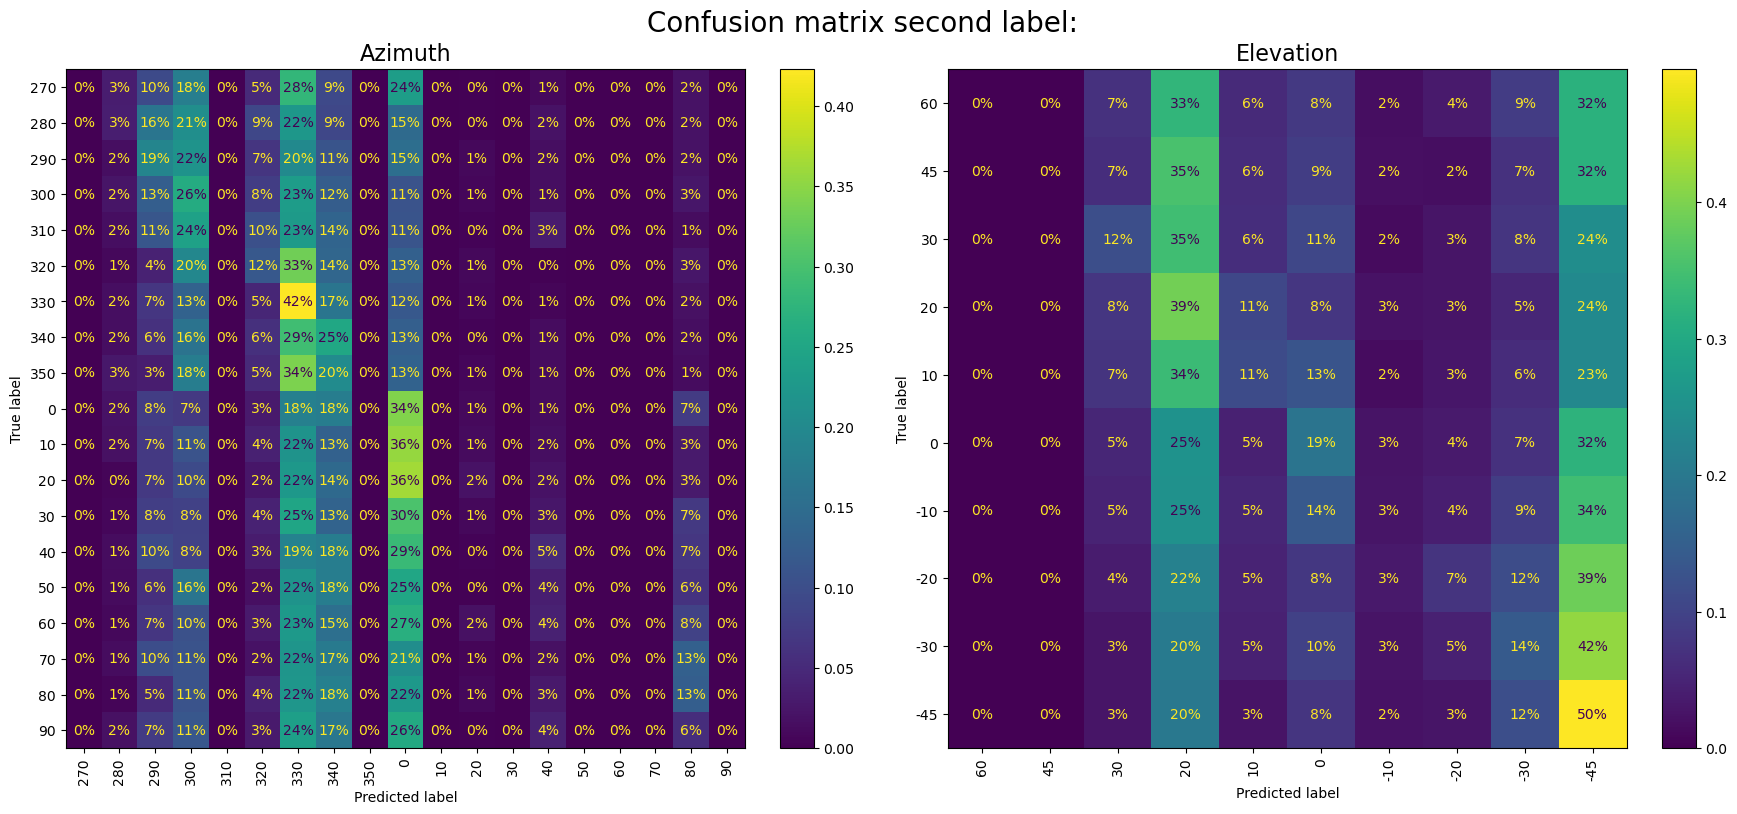

In [3]:
# Plot results of multi-source model
predict = np.load('final_predictions/goodEpoch_MultiSource.npz')['arr_0'] #load output arrays
max_preds, max_probs = max_multi_pred(predict)
true = np.load('name_labels_test_multi.npz')['arr_1']
true_labels = true[:predict.shape[0]] # make sure the predictions.size == trues.size because batch size gives modulo>0

correct_pred_pairs = extract_label_pairs(true_labels, max_preds)

#plot confusion matrices of all labels (1st and 2nd, so flattened array)
full_true = true_labels.flatten()
full_pred = correct_pred_pairs.flatten()
confusion_matrices(full_true, full_pred, "all labels:")

# plot only first label
first_true = label_spec(true_labels, 0)
first_pred = label_spec(correct_pred_pairs, 0)
confusion_matrices(first_true, first_pred, "first label:")

#plot only second label
sec_true = label_spec(true_labels, 1)
sec_pred = label_spec(correct_pred_pairs, 1)
confusion_matrices(sec_true, sec_pred, "second label:")



total accuracy:  0.011899747262005055
accuracy azimuth:  0.09883108677337826
accuracy elevation:  0.16628053917438923


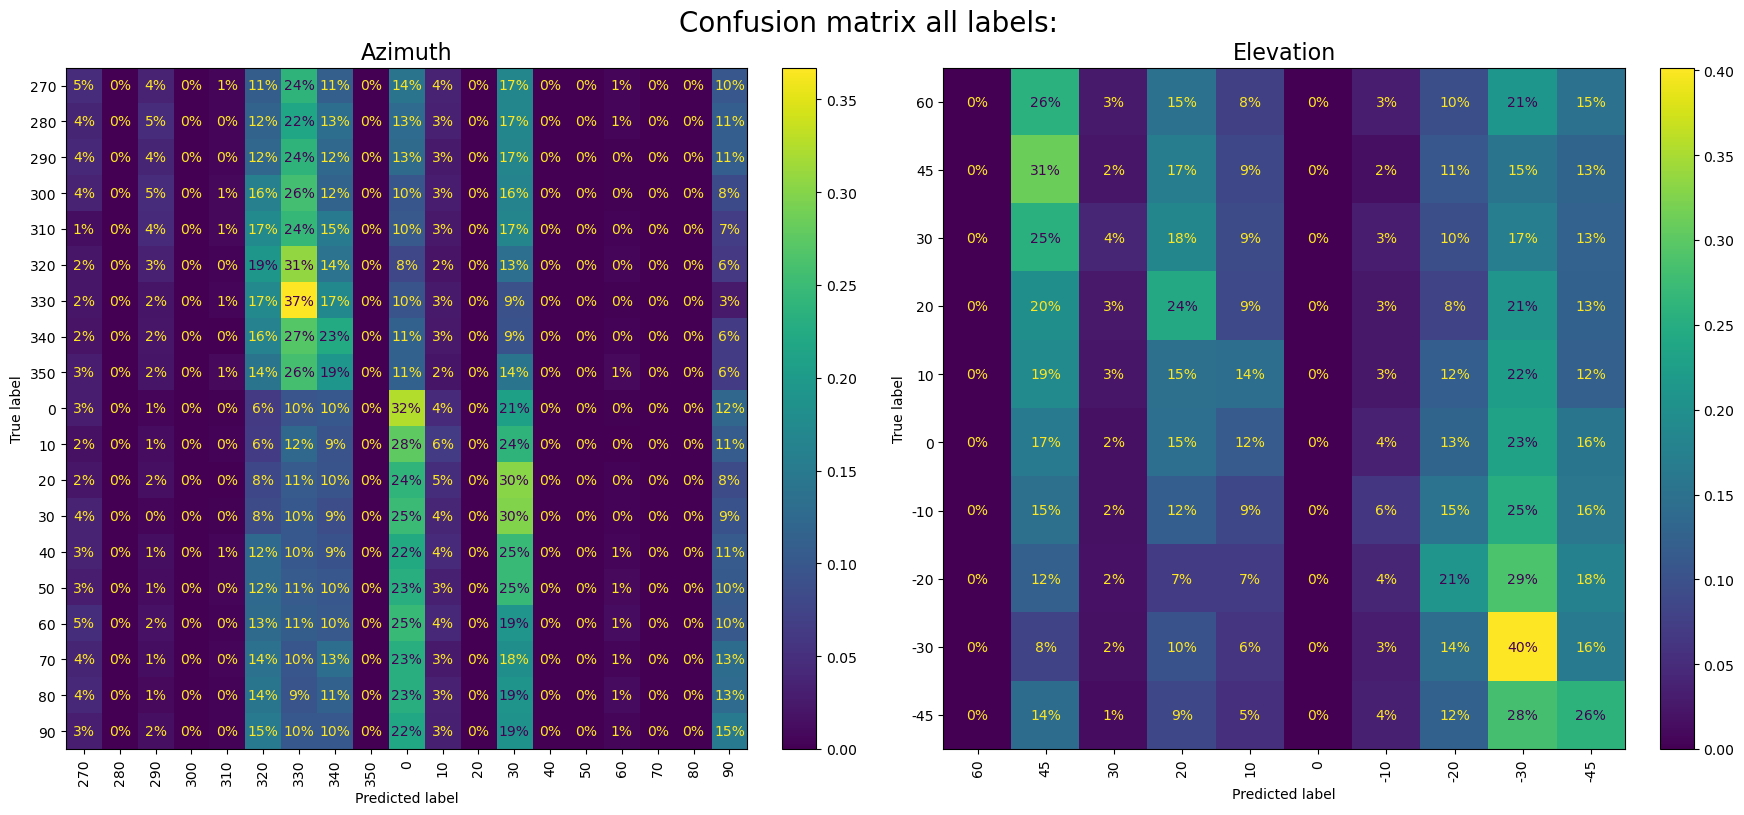

total accuracy:  0.009477674810446503
accuracy azimuth:  0.09446082561078349
accuracy elevation:  0.1707034540859309


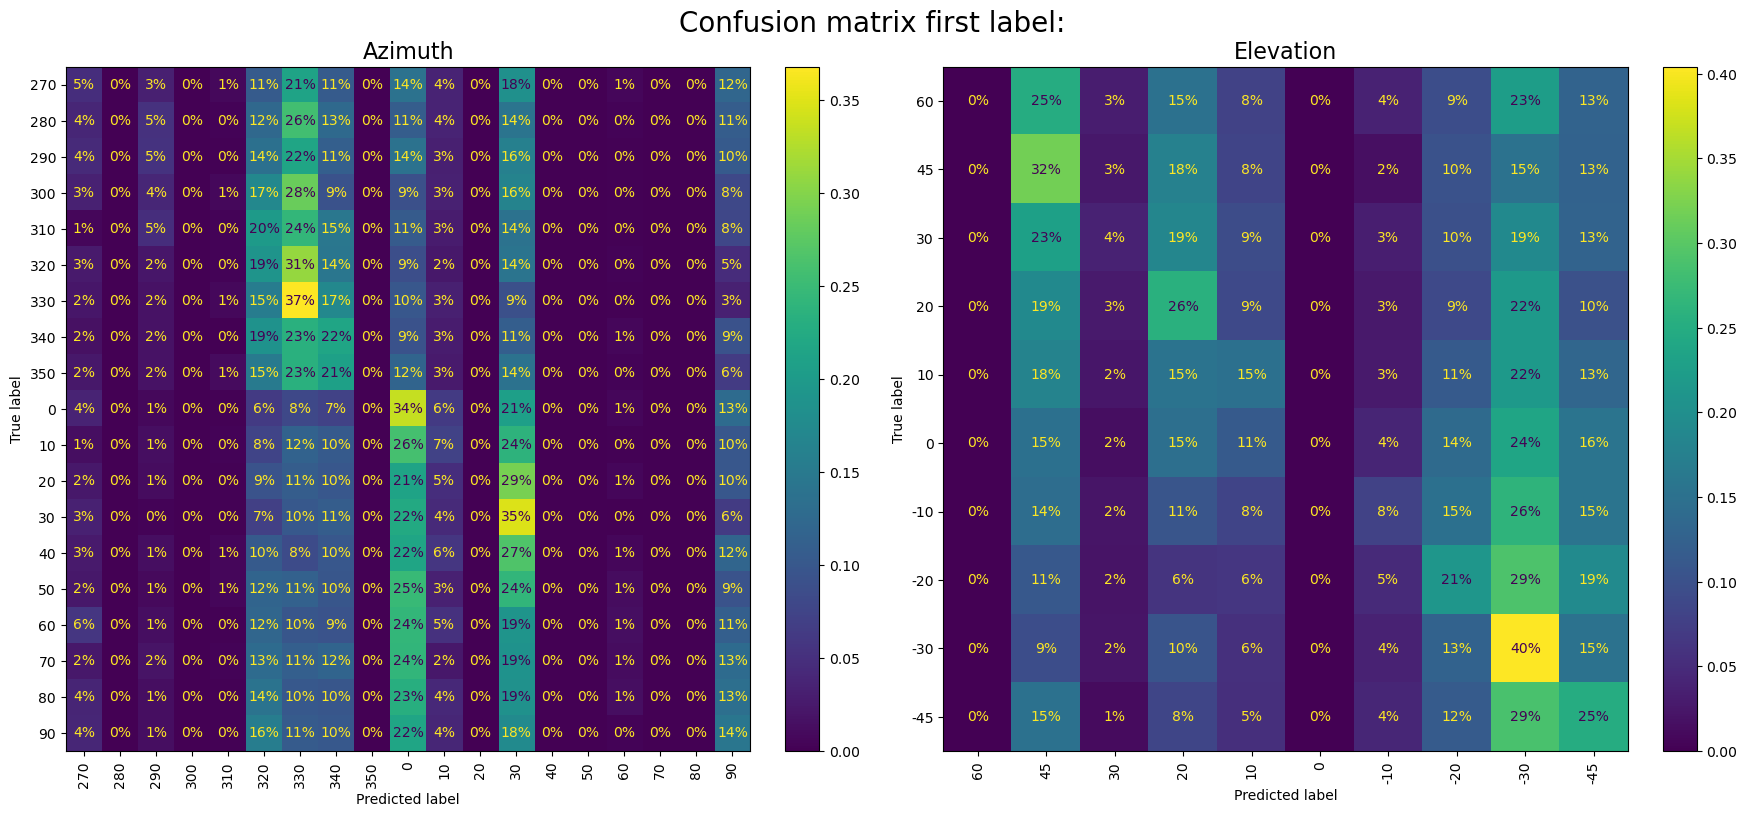

total accuracy:  0.014321819713563605
accuracy azimuth:  0.10320134793597305
accuracy elevation:  0.16185762426284753


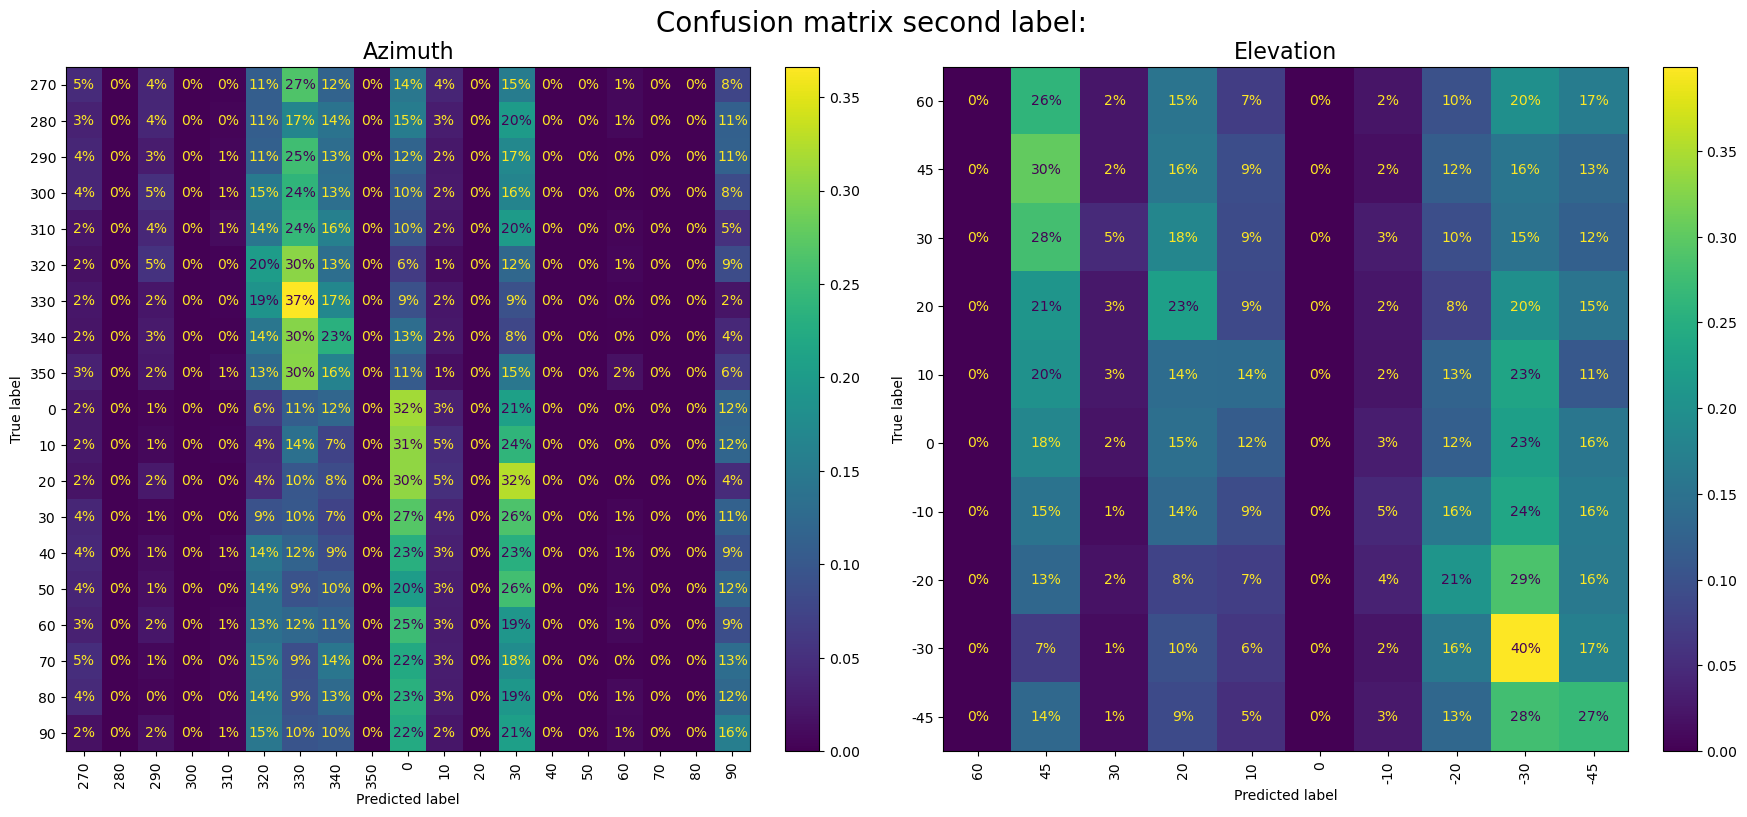

In [4]:
#plot results of altered multi-source model (with learning rate of 1e-5)
predict = np.load('final_predictions/goodEpoch_MultiSource_LR_1e-5.npz')['arr_0'] #load output array
max_preds, max_probs = max_multi_pred(predict)
true = np.load('name_labels_test_multi.npz')['arr_1']
true_labels = true[:predict.shape[0]] # make sure the predictions.size == trues.size because batch size gives modulo>0

correct_pred_pairs = extract_label_pairs(true_labels, max_preds)

#plot confusion matrices of all labels (1st and 2nd, so flattened array)
full_true = true_labels.flatten()
full_pred = correct_pred_pairs.flatten()
confusion_matrices(full_true, full_pred, "all labels:")

# plot only first label
first_true = label_spec(true_labels, 0)
first_pred = label_spec(correct_pred_pairs, 0)
confusion_matrices(first_true, first_pred, "first label:")

#plot only second label
sec_true = label_spec(true_labels, 1)
sec_pred = label_spec(correct_pred_pairs, 1)
confusion_matrices(sec_true, sec_pred, "second label:")
